In [1]:
from TrafficLight import PeriodicTrafficLight, AdaptiveTrafficLight, TrafficLightMirror
import Model1
import Model2
from ModelEvaluation import Evaluator, MultiEvaluator
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import pickle

*Periodic traffic lights*

In [2]:
light_ew = PeriodicTrafficLight()
light_ew.initialize(period=30, time_delay=0, green_ratio=0.8)

light_ns = TrafficLightMirror()
light_ns.initialize(traffic_light=light_ew)

*Adaptive traffic lights*

In [3]:
light_ew = AdaptiveTrafficLight()
light_ew.initialize(sensor_depth=8, rule=1)

light_ns = TrafficLightMirror()
light_ns.initialize(traffic_light=light_ew)

In [4]:
network = Model1.IntersectionNetworkSimulator()
network.initialize(grid_dimensions=(1,1))
network.set_queue_rate_parameters(grid_ind=(0,0), avg_departure_time=0.5, avg_arrival_time_n=4, avg_arrival_time_e=3, avg_arrival_time_s=4, avg_arrival_time_w=3)
network.set_traffic_lights(grid_ind=(0,0), traffic_light_ns=light_ns, traffic_light_ew=light_ew)
network.set_observable_intersections(grid_inds=network.grid_inds)

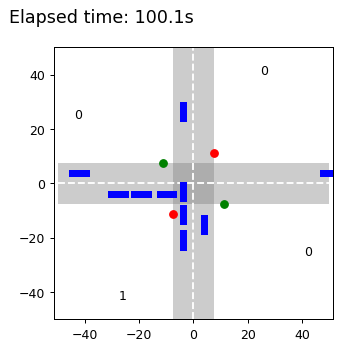

In [5]:
network.simulate(delta_t=0.1, end_time=100, animate=True, fig_width=4, file_name="figs/simulation_1x1.mp4", speed=1)

In [6]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="figs/simulation_1x1.mp4" type="video/mp4">
</video></div>""")

In [7]:
stats = network.get_stats()
print("Average wait time:", stats[(0,0)]["N"]["wait_time"], "s")
print("Average queue length: ", stats[(0,0)]["N"]["avg_queue_length"], "vehicles")

Average wait time: 1.2499999999999993 s
Average queue length:  0.3176823176823177 vehicles


In [8]:
print("Average wait time:", stats[(0,0)]["E"]["wait_time"], "s")
print("Average queue length: ", stats[(0,0)]["E"]["avg_queue_length"], "vehicles")

Average wait time: 0.6846153846153847 s
Average queue length:  0.2987012987012987 vehicles


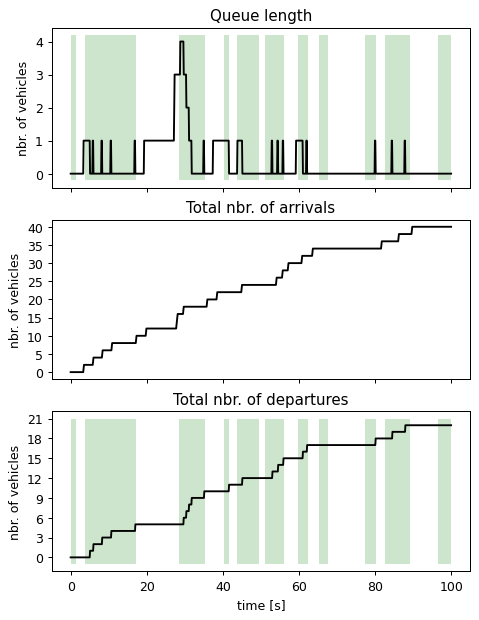

In [9]:
fig, axs = network.plot_queue_stats(plt=plt, grid_ind=(0,0), direction='N', end_time=100, delta_t=0.1, traffic_light=light_ns,fig_size=(6,8))
plt.savefig('figs/eastbound_(0,0)', bbox_inches='tight')

In [10]:
time = network.time
switches_ns = network.intersections[(0,0)].traffic_light_ns.switches
switch_inds_ns = list(np.array(range(int(round(time/0.1,3))+1))[list(map(lambda x: True if x>0 else False, switches_ns))])
switches_ew = network.intersections[(0,0)].traffic_light_ew.switches
switch_inds_ew = list(np.array(range(int(round(time/0.1,3))+1))[list(map(lambda x: True if x>0 else False, switches_ew))])

print(switch_inds_ns) # time index when green-to-red switch occurs (index = # of time-steps)
print(switch_inds_ew)

[38, 284, 403, 438, 510, 597, 652, 773, 825, 965]
[15, 172, 353, 418, 495, 561, 623, 678, 803, 893]


In [11]:
durations_ns = []
durations_ew = []
for i in range(1,len(switch_inds_ns)):
    durations_ns += [0.1*(switch_inds_ns[i]-switches_ns[i-1])]
    durations_ew += [0.1*(switch_inds_ew[i]-switches_ew[i-1])]
    
print(durations_ns) # red-green cycle durations (aka time between green-to-red switches)
print(durations_ew)

[28.400000000000002, 40.300000000000004, 43.800000000000004, 51.0, 59.7, 65.2, 77.30000000000001, 82.5, 96.5]
[17.2, 35.300000000000004, 41.800000000000004, 49.5, 56.1, 62.300000000000004, 67.8, 80.30000000000001, 89.30000000000001]


In [12]:
num_vehicles = network.intersections[(0,0)].num_queued_vehicles # tot. queued vehicles over time
growths_ns = []
growths_ew = []
for i in range(1, len(switch_inds_ns)):
    growths_ns += [num_vehicles[switch_inds_ns[i]]-num_vehicles[switch_inds_ns[i-1]]]
    growths_ew += [num_vehicles[switch_inds_ew[i]]-num_vehicles[switch_inds_ew[i-1]]]

print(growths_ns) # growth between start and end of each cycle
print(growths_ew)

[2, -3, -1, 0, 3, -2, 1, -2, 1]
[5, -4, -1, 0, 2, -2, 0, 1, 3]


In [13]:
cum_rate_ns = 0
cum_rate_ew = 0
for i in range(len(switch_inds_ns)-1):
    cum_rate_ns += growths_ns[i]/durations_ns[i]
    cum_rate_ew += growths_ew[i]/durations_ew[i]

In [14]:
print(cum_rate_ns/len(switch_inds_ns), cum_rate_ew/len(switch_inds_ew)) # clearance rate

-0.0008216912040201303 0.02030556019889913
